In [145]:
from src.utils.visualization import plot_scatter, read_data
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import os, json, pickle, sys, torch
from scipy.stats import gaussian_kde
import seaborn as sns
from pathlib import Path
plt.rcParams['font.size'] = 13

In [146]:
cmap1 = lambda x: [np.min([x*2+0.5,1]), x*0.8, x*0.6]
cmap2 = lambda x: [x*0.7, np.min([x*2+0.2,1]), np.min([x*0.7+0.2, 1])]
cmap3 = lambda x: [x*0.3, x*0.9, np.min([x*2+0.5, 1])]

def get_output(root, tag, summary=False, fmt='n_{:03d}', epoch='best',
               dataset=['train','valid','test'], verbose=False):
    output = {ds:[] for ds in dataset}
    path = os.path.join(root, tag)
    if not os.path.isdir(path):
        return output
    for i in range(100):
        dn = os.path.join(path, fmt.format(i))
        for ds in dataset:
            dfn = os.path.join(dn, f'{epoch}.{ds}.pkl')
            if not os.path.isfile(dfn): 
                continue
            with open(dfn, 'rb') as f:
                ids, tgts, preds = pickle.load(f)
            o = np.argsort(ids)
            ids = ids[o]
            tgts = tgts[o]
            preds = preds[o]
            output[ds].append([ids, tgts, preds])
    if verbose:
        ps =  [f'{tag:8s} //' + ''.join([f'{ds:>12} (R2/RMSE/MAE) //' for ds in dataset])]
        ps += [f'Fold: {k:2d} // ' for k in range(len(output['train']))]
        ps += ['AVG:     // ']
        ps += ['STD:     // ']
        ps += ['ALL:     // ' + '        /'*3 + '/ ']
        for i, (ds, d1) in enumerate(output.items()):
            ms = []
            for j, (_, t, p) in enumerate(d1):
                ms.append([r2_score(t, p), np.sqrt(mean_squared_error(t, p)), mean_absolute_error(t, p)])
                ps[j+1] += '{:7.3f} / {:6.2f} / {:6.2f} // '.format(*ms[-1])
            avg = np.mean(ms, axis=0)
            std = np.std(ms, axis=0)
            ps[-3] += ' {:6.3f} / {:6.2f} / {:6.2f} // '.format(*avg)
            ps[-2] += ' ±{:5.3f} / ±{:5.2f} / ±{:5.2f} // '.format(*std)
            if ds == 'valid':
                t, p = np.vstack([np.hstack([t, p]) for _, t, p in d1]).T
                ps[-1] += ' {:6.3f} / {:6.2f} / {:6.2f} // '.format(r2_score(t, p), np.sqrt(mean_squared_error(t, p)), mean_absolute_error(t, p))
            elif ds == 'test':
                t = d1[0][1]
                p = np.median(np.hstack([p for _, t, p in d1]), axis=1)
                ps[-1] += ' {:6.3f} / {:6.2f} / {:6.2f} // '.format(r2_score(t, p), np.sqrt(mean_squared_error(t, p)), mean_absolute_error(t, p))
        print(ps[0])
        print('-'*len(ps[1]))
        if not summary:
            for p in ps[1:-3]:
                print(p)
            print('-'*len(ps[1]))
        print(ps[-3])
        print(ps[-2])
        print(ps[-1])
    return output

def get_cvout(root='/home/jhyang/WORKSPACES/MODELS/fpoly/r100/', metric=['R2','MAE']):
    cv_errs = {}
    for model in ['scratch','finetune']:
        _root = os.path.join(root, f'{model}_cs')
        nets = ['mol','graph','concat']
        for cond in sorted(os.listdir(_root)):
            path_cond = os.path.join(_root, cond)
            cond = cond.replace('_s0','_s')
            for net in nets:
                path = os.path.join(path_cond, net)
                if not os.path.isdir(path): continue
                for tag in sorted(os.listdir(path)):
                    if f'{cond}_{net}_{tag}' not in cv_errs.keys():
                        cv_errs[f'{cond}_{net}_{tag}'] = {
                            'train':{'scratch':{},'finetune':{}}, 
                            'valid':{'scratch':{},'finetune':{}}, 
                            'test':{'scratch':{},'finetune':{}},
                            'score':{'scratch':{},'finetune':{}},
                        }
                    path_tag = os.path.join(path, tag)
                    output = get_output(path, tag, fmt='n_{:03d}', epoch='best')
                    mfn = os.path.join(path_tag, 'n_000/best.model.torch')
                    if not os.path.isfile(mfn): continue
                    line = f'{net:10s}/{tag:20s} {cond:20s} / '
                    score = np.zeros(5)
                    for ds in ['train','valid','test']:
                        out = output[ds]
                        errs = []
                        for _, ts, ps in out:
                            err = []
                            for t, p in zip(ts.T, ps.T):
                                err.append([
                                    r2_score(t, p), 
                                    np.sqrt(mean_squared_error(t, p)), 
                                    mean_absolute_error(t, p)])
                            errs.append(err)
                        if len(errs) == 0: 
                            line += '||'
                            continue
                        ts = [o[1].reshape(-1) for o in out]
                        ps = [o[2].reshape(-1) for o in out]
                        r2, rmse, mae = np.array(errs).transpose(2, 1, 0)
                        cv_errs[f'{cond}_{net}_{tag}'][ds][model]['r2'] = r2.squeeze()
                        cv_errs[f'{cond}_{net}_{tag}'][ds][model]['rmse'] = rmse.squeeze()
                        cv_errs[f'{cond}_{net}_{tag}'][ds][model]['mae'] = mae.squeeze()
                        cv_errs[f'{cond}_{net}_{tag}'][ds][model]['raw'] = ps
                        cv_errs[f'{cond}_{net}_{tag}'][ds][model]['target'] = ts
                        if ds != 'test':
                            score += r2.squeeze() - 0.02 * mae.squeeze()
                        for s, val in zip(['R2','RMSE','MAE'], [r2, rmse, mae]):
                            if s not in metric: continue
                            avg = np.mean(val)
                            std = np.std(val)
        #                    print(ds, '\t', s, '\t/ ', ' / '.join([f'{v:6.3f} ±{e:.3f}' for v, e in zip(avg, std)]))
                            line += f' {avg:6.3f} ±{std:.3f} /'
                        line += '/'
                    cv_errs[f'{cond}_{net}_{tag}']['score'][model] = score
    return cv_errs

In [147]:
metrics = ['r2','mae','rmse']
models = ['scratch','finetune']
cv_errs = get_cvout()
tags = np.array([k for k in cv_errs.keys()])
errs_bf = {i:{met:{m:[] for m in models} for met in metrics} for i in range(5)}
pred_bf = {i:{ds:{m:[] for m in models} for ds in ['train','valid','test']} for i in range(5)}
tgts_bf = {i:{ds:None for ds in ['train','valid','test']} for i in range(5)}
scor_bf = {i:{m:None for m in models} for i in range(5)}

valid_r2s = {model:np.array([v['valid'][model]['r2'] for v in cv_errs.values()]).T for model in ['scratch','finetune']}
valid_maes = {model:np.array([v['valid'][model]['mae'] for v in cv_errs.values()]).T for model in ['scratch','finetune']}
train_r2s = {model:np.array([v['train'][model]['r2'] for v in cv_errs.values()]).T for model in ['scratch','finetune']}
train_maes = {model:np.array([v['train'][model]['mae'] for v in cv_errs.values()]).T for model in ['scratch','finetune']}
test_r2s = {model:np.array([v['test'][model]['r2'] for v in cv_errs.values()]).T for model in ['scratch','finetune']}
test_maes = {model:np.array([v['test'][model]['mae'] for v in cv_errs.values()]).T for model in ['scratch','finetune']}
valid_scors = {model:r - 0.05 * m for (model, r), m in zip(valid_r2s.items(), valid_maes.values())}

for v1 in cv_errs.values():
    for m in models:
        for metric in metrics:
            for i in range(5):
                errs_bf[i][metric][m].append([
                    v1['train'][m][metric][i], v1['valid'][m][metric][i], v1['test'][m][metric][i]
                ])
        for i in range(5):
            for ds in ['train','valid','test']:
                pred_bf[i][ds][m].append(v1[ds][m]['raw'][i])
for ds in ['train','valid','test']:
    for i in range(5):
        tgts_bf[i][ds] = v1[ds]['scratch']['target'][i]
for i in range(5):
    for m in models:
        rt, rv, _ = np.array(errs_bf[i]['r2'][m]).T
        mt, mv, _ = np.array(errs_bf[i]['mae'][m]).T
        s = rt + rv - (mt + mv) * 0.02
#        s[rt < 0.9] = 0
        scor_bf[i][m] = s

pred_best = {}
for model in ['scratch','finetune']:
    pred_best[model] = {'train':[],'valid':[], 'test':[]}
    for i,j in enumerate(valid_r2s[model].argmax(1)):
        pred_best[model]['train'].append(pred_bf[i]['train'][model][j])
        pred_best[model]['valid'].append(pred_bf[i]['valid'][model][j])
        pred_best[model]['test'].append(pred_bf[i]['test'][model][j])

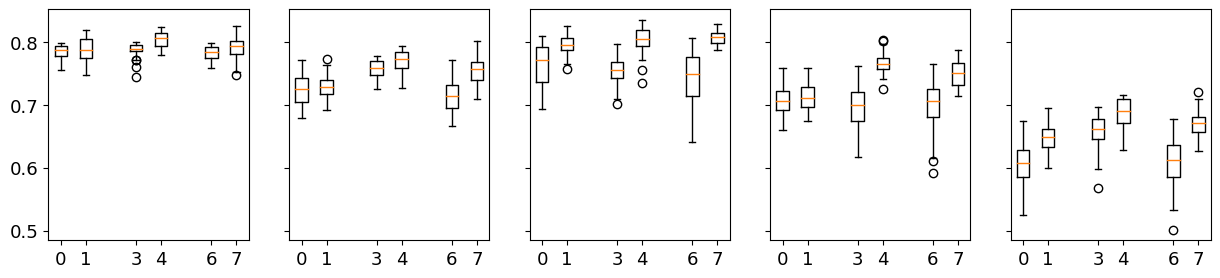

In [138]:
f, axs = plt.subplots(1,5,figsize=(15, 3), sharey=True)
for i, ax in enumerate(axs):
    for j, model in enumerate(['scratch','finetune']):
        val = valid_r2s[model][i]
        for k, tag in enumerate(['mol','graph','concat']):
            mask = np.array([(tag in _tag) and ('b64' not in _tag) for _tag in tags])
            ax.boxplot(val[mask], positions=[j + k*3], widths=0.5)
#            ax.scatter([j+k*3]*np.sum(mask), val[mask], facecolor=[0.3,0.3,0.3], edgecolor=[0,0,0], alpha=0.5)
            
            #ax.violinplot(val[mask], positions=[j+k*3])
            #sns.swarmplot(val[mask], , ax=ax)

In [5]:
for model, v1 in valid_r2s.items():
    for i, j in enumerate(v1.argmax(1)):
        t = tags[j]
        v = v1[i,j]
        p = os.path.join(f'/home/jhyang/WORKSPACES/MODELS/fpoly/r100/{model}_cs',
        '_'.join(t.split('_')[:3]), t.split('_')[3], '_'.join(t.split('_')[4:]), f'n_00{i}'
        )
        lr = open(os.path.join(p,'best.params.txt')).readlines()[1]
        print('_'.join(t.split('_')[:3]), t.split('_')[3], '_'.join(t.split('_')[4:]), lr)
    print()

b16_g75_s25 concat sing_cg_64.128_6.2 lr: 0.004509077810913175
b16_g75_s25 graph sing_cg_64_6 lr: 0.0038154532369402768
b04_g99_s25 mol sing_dnn_256_2 lr: 0.00023151681330525954
b04_g99_s25 concat sing_cg_64.128_6.2 lr: 0.0005378223215436628
b04_g95_s25 graph sing_cg_64_4 lr: 0.0027752746051893126

b16_g75_s25 concat sing_cg_64.128_6.2 lr: 0.01705095246980882
b08_g95_s25 concat sing_cg_64.128_6.2 lr: 0.003039601569683528
b08_g75_s25 graph sing_cg_64_6 lr: 0.0018204112840396558
b04_g95_s50 graph sing_cg_64_4 lr: 0.00019844699710266055
b16_g95_s25 concat sing_cg_64.256_4.2 lr: 0.003312029155594334



In [166]:
import shutil

for model, v1 in valid_r2s.items():
    for i, j in enumerate(v1.argmax(1)):
        t = tags[j]
        v = v1[i,j]
        p = os.path.join(f'/home/jhyang/WORKSPACES/MODELS/fpoly/r100/{model}_cs',
        '_'.join(t.split('_')[:3]), t.split('_')[3], '_'.join(t.split('_')[4:]), f'n_00{i}'
        )
        print(p)
        os.makedirs(f'/home/jhyang/WORKSPACES/MODELS/fpoly/r100/Final/{model}/n_00{i}', exist_ok=True)
        with open(f'/home/jhyang/WORKSPACES/MODELS/fpoly/r100/Final/{model}/n_00{i}/tag.txt','w') as f:
            f.write(' '.join(['_'.join(t.split('_')[:3]), t.split('_')[3], '_'.join(t.split('_')[4:])]))
        for fn in os.listdir(p):
            if fn.startswith('i') or fn.startswith('l'): continue
            shutil.copy(os.path.join(p, fn), 
                        os.path.join(f'/home/jhyang/WORKSPACES/MODELS/fpoly/r100/Final/{model}/n_00{i}', fn.replace('best.','')))
#            print('\t',fn)
        
#            with open(os.path.join(p, f'{ds}.pkl'),'rb') as f:
#                data = pickle.load(f)
#            tr = data[1].reshape(-1)
#            pd = data[2].reshape(-1)
#            s += ' | {:7.4f} / {:8.4f}'.format(r2_score(tr, pd), mean_absolute_error(tr, pd))
#        print(s)

/home/jhyang/WORKSPACES/MODELS/fpoly/r100/scratch_cs/b32_g95_s25/graph/sing_cg_64_4/n_000
/home/jhyang/WORKSPACES/MODELS/fpoly/r100/scratch_cs/b08_g99_s50/graph/sing_cg_64_6/n_001
/home/jhyang/WORKSPACES/MODELS/fpoly/r100/scratch_cs/b04_g75_s50/mol/sing_dnn_256_2/n_002
/home/jhyang/WORKSPACES/MODELS/fpoly/r100/scratch_cs/b08_g75_s25/concat/sing_cg_64.128_6.2/n_003
/home/jhyang/WORKSPACES/MODELS/fpoly/r100/scratch_cs/b08_g99_s50/graph/sing_cg_64_4/n_004
/home/jhyang/WORKSPACES/MODELS/fpoly/r100/finetune_cs/b32_g99_s50/concat/sing_cg_64.256_4.2/n_000
/home/jhyang/WORKSPACES/MODELS/fpoly/r100/finetune_cs/b04_g95_s50/concat/sing_cg_64.128_6.2/n_001
/home/jhyang/WORKSPACES/MODELS/fpoly/r100/finetune_cs/b04_g99_s25/mol/sing_dnn_256_2/n_002
/home/jhyang/WORKSPACES/MODELS/fpoly/r100/finetune_cs/b16_g95_s50/concat/sing_cg_64.128_6.2/n_003
/home/jhyang/WORKSPACES/MODELS/fpoly/r100/finetune_cs/b16_g95_s25/concat/sing_cg_64.256_4.2/n_004


In [167]:
outputs = {
    'valid':{
        'scratch':{
            'pred':[],
            'target':[],
        },
        'finetune':{
            'pred':[],
            'target':[],
        }
    },
    'test':{
        'scratch':{
            'pred':[],
            'target':[],
        },
        'finetune':{
            'pred':[],
            'target':[],
        }
    }    
}
for model in ['scratch','finetune']:
    for i in range(5):
        for ds in ['valid','test']:
            with open(f'/home/jhyang/WORKSPACES/MODELS/fpoly/r100/Final/{model}/n_00{i}/{ds}.pkl','rb') as f:
                v = pickle.load(f)
            outputs[ds][model]['pred'].append(v[2].reshape(-1))
            outputs[ds][model]['target'].append(v[1].reshape(-1))

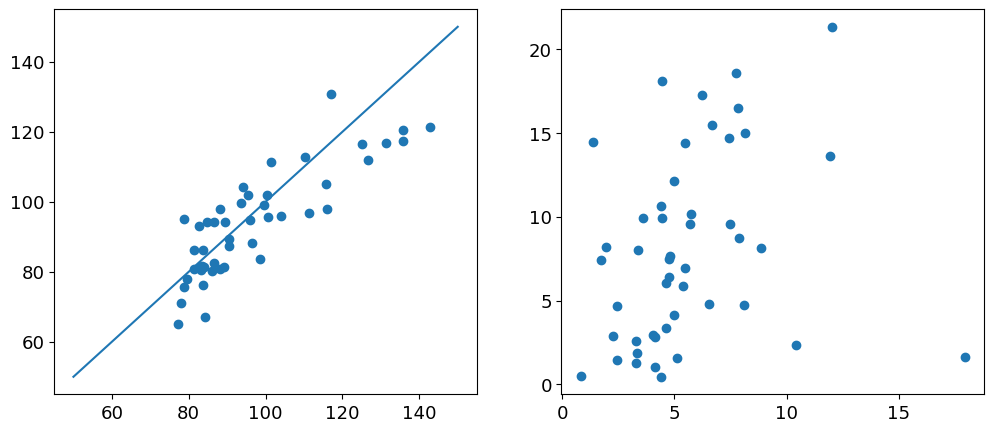

In [168]:
ft_p = outputs['test']['finetune']['pred']
unc = np.std(ft_p, 0)
val = outputs['test']['finetune']['target'][0]
prd = np.mean(ft_p, 0)
f, axs = plt.subplots(1,2,figsize=(12, 5))
axs[0].scatter(val, prd)
axs[1].scatter(unc, np.abs(val-prd))
axs[0].plot([50,150],[50,150])

In [150]:
with open('/home/jhyang/WORKSPACES/MODELS/fpoly/r100/Final/finetune/n_001/tag.txt') as f:
    print(f.read())

b08_g95_s50 concat sing_cg_64.128_6.2


0 (49,)
1 (49,)
2 (49,)
3 (49,)
4 (49,)
0 (49,)
1 (49,)
2 (49,)
3 (49,)
4 (49,)


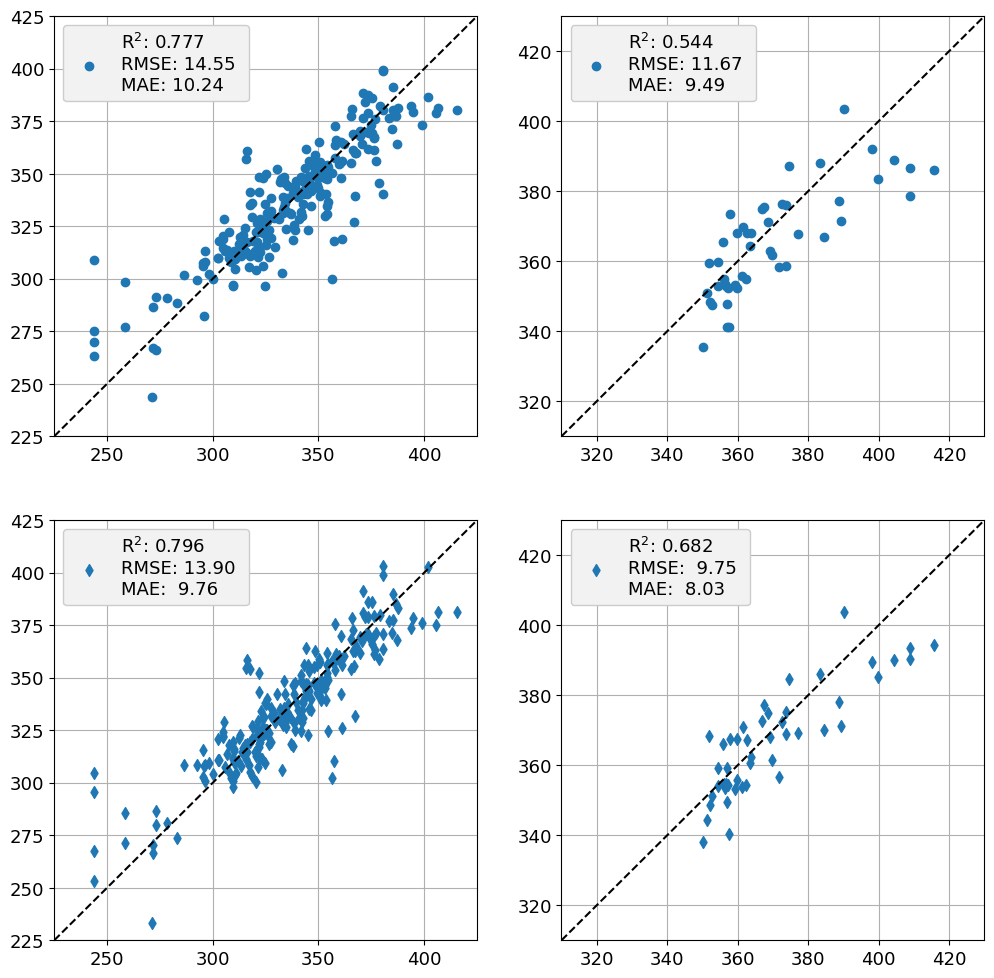

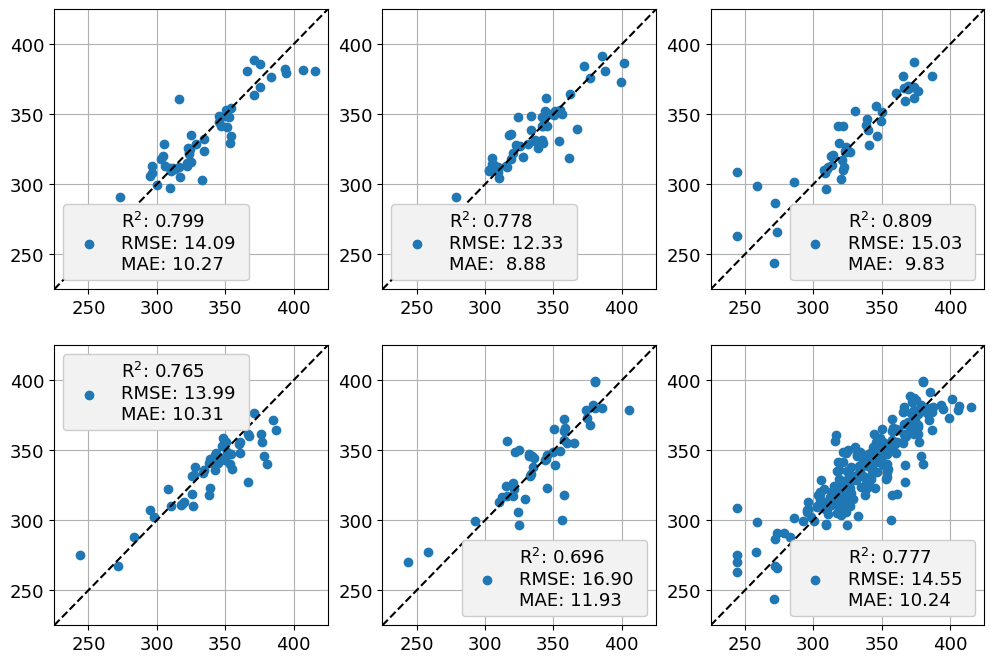

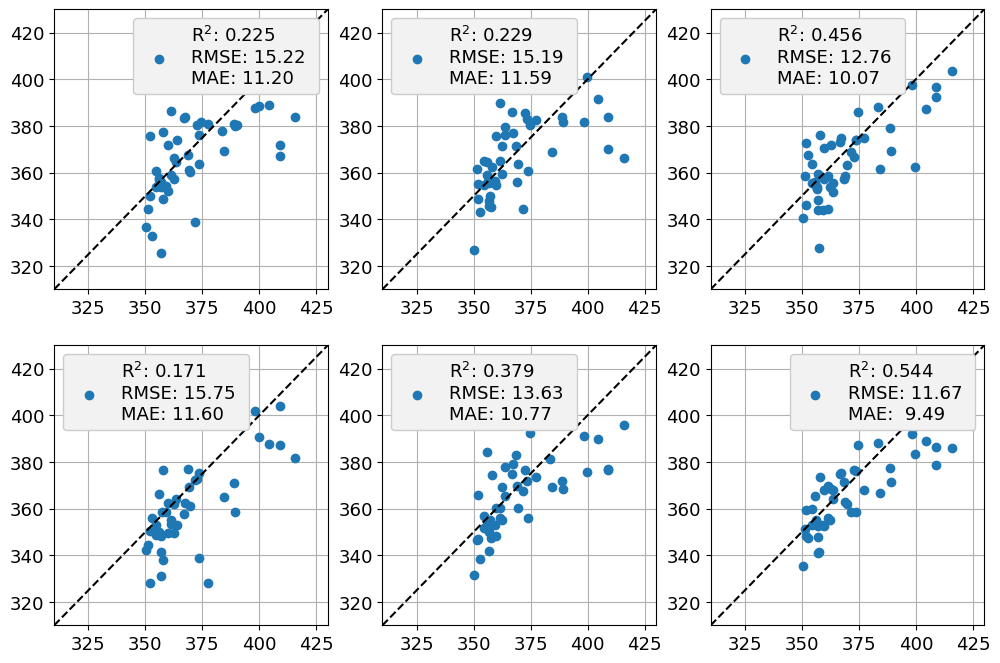

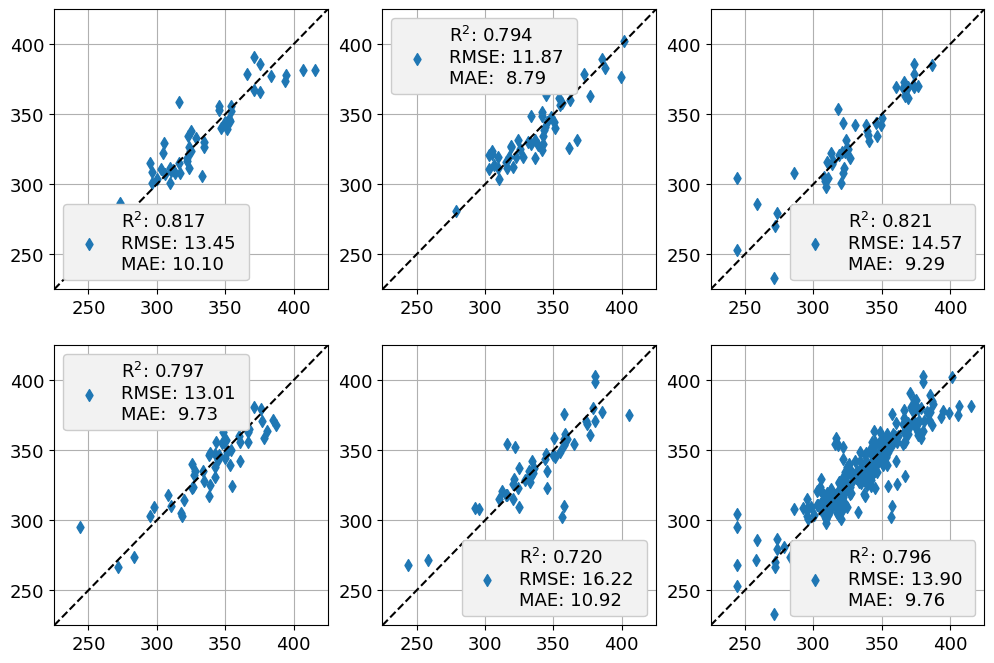

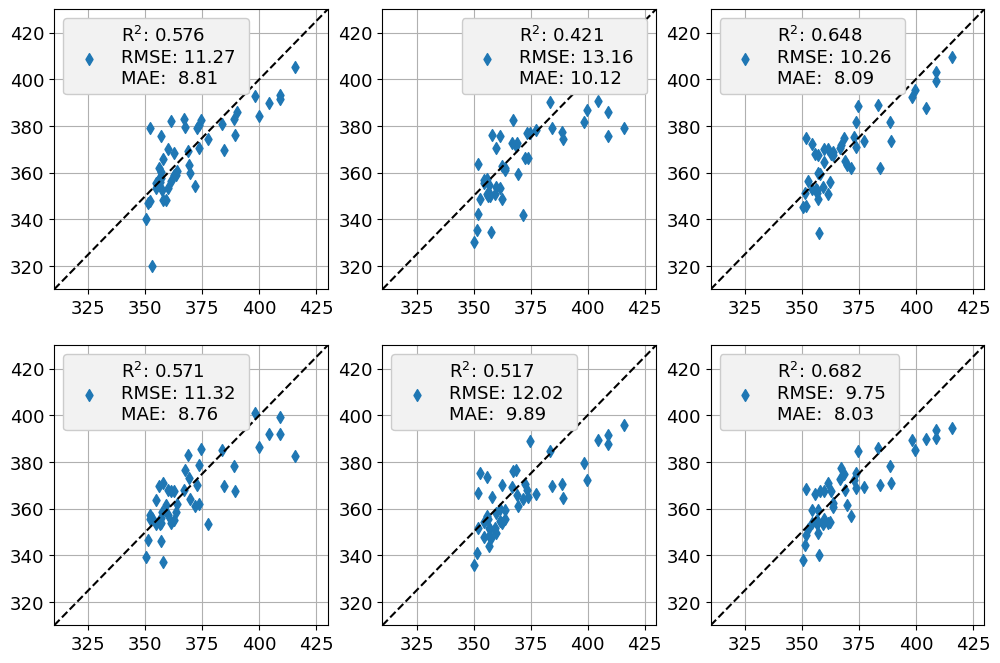

In [169]:
f1, axs1 = plt.subplots(2,2,figsize=(12,12))
marker = ['o','d']
for i, model in enumerate(['scratch','finetune']):
    x1 = np.hstack(outputs['valid'][model]['target']) + 273.15
    y1 = np.hstack(outputs['valid'][model]['pred']) + 273.15
    x2 = outputs['test'][model]['target'][0] + 273.15
    y2 = np.mean(outputs['test'][model]['pred'], 0) + 273.15
    plot_scatter(axs1[i,0], x1, y1, xrange=[225, 425], marker=marker[i])
    plot_scatter(axs1[i,1], x2, y2, xrange=[310, 430], marker=marker[i])

    f2, axs2 = plt.subplots(2,3,figsize=(12,8))
    axs2 = axs2.reshape(-1)
    for j in range(5):
        x0 = outputs['valid'][model]['target'][j] + 273.15
        y0 = outputs['valid'][model]['pred'][j] + 273.15
        print(j, y0.shape)
        plot_scatter(axs2[j], x0, y0, xrange=[225, 425], marker=marker[i])
    plot_scatter(axs2[-1], x1, y1, xrange=[225,425], marker=marker[i])
    f2.savefig(f'./figs/output.{model}.valid.pdf')

    f2, axs2 = plt.subplots(2,3,figsize=(12,8))
    axs2 = axs2.reshape(-1)
    for j in range(5):
        y3 = outputs['test'][model]['pred'][j] + 273.15
        plot_scatter(axs2[j], x2, y3, xrange=[310, 430], marker=marker[i])
    plot_scatter(axs2[-1], x2, y2, xrange=[310,430], marker=marker[i])
    f2.savefig(f'./figs/output.{model}.test.pdf')
f1.savefig(f'./figs/output.all.valid.pdf')

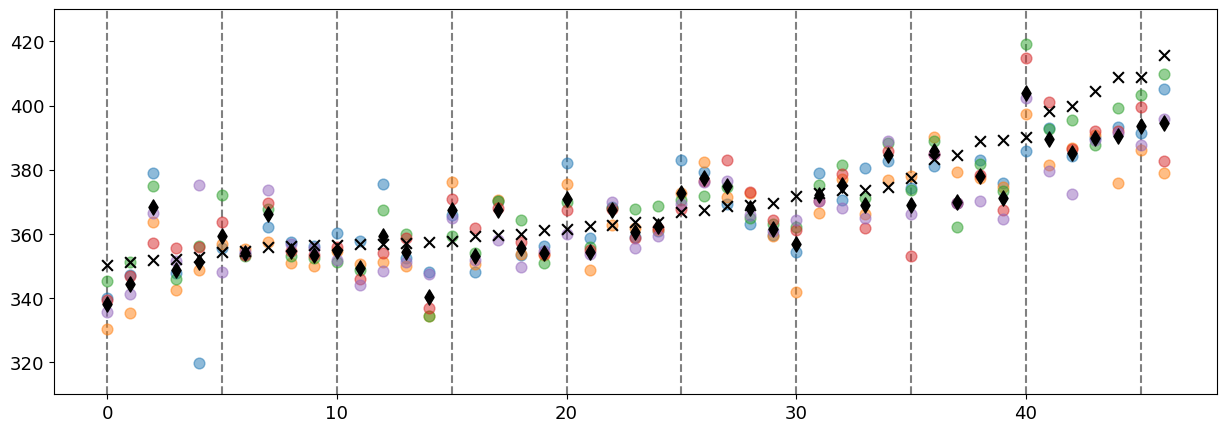

In [217]:
f, ax = plt.subplots(1,1,figsize=(15,5))
ps = outputs['test']['finetune']['pred']
t = outputs['test']['finetune']['target'][0] + 273.15
x = np.arange(t.shape[0])
x = np.argsort(t).argsort()
for i in range(10):
    ax.axvline(i*5, ls='--', color=[0.5,0.5,0.5])
for i, p in enumerate(ps):
    ax.scatter(x, p+273.15, zorder=80, alpha=0.5, s=60)
ax.scatter(x, t, marker='x', color=[0,0,0], zorder=95, s=60)
ax.scatter(x, np.mean(ps, 0)+273.15, marker='d', color=[0,0,0], zorder=95, s=60)
ax.set_ylim([310,430])
f.savefig('./figs/output.test.support.all.pdf')

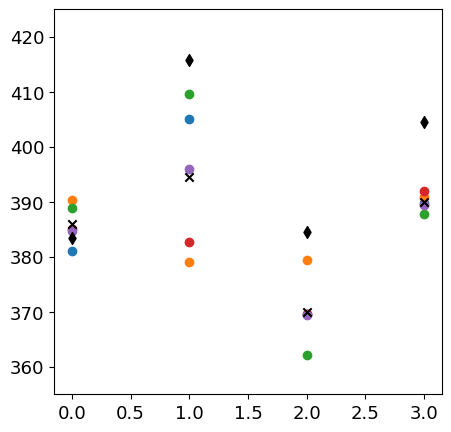

In [200]:
vals = np.vstack(outputs['test']['finetune']['pred'] + [np.mean(outputs['test']['finetune']['pred'], 0), outputs['test']['finetune']['target'][0]]).T + 273.15
f, ax = plt.subplots(1,1,figsize=(5,5))
for j, i in enumerate([6,7,11,29]):
    a, b, c, d, e, ens, t = vals[i]
    ax.scatter(j, a, color=mpl.cm.tab10(0))
    ax.scatter(j, b, color=mpl.cm.tab10(1))
    ax.scatter(j, c, color=mpl.cm.tab10(2))
    ax.scatter(j, d, color=mpl.cm.tab10(3))
    ax.scatter(j, e, color=mpl.cm.tab10(4))
    ax.scatter(j, t, marker='d', color=[0,0,0])
    ax.scatter(j, ens, marker='x', color=[0,0,0])
ax.set_ylim([355, 425])

f.savefig('./figs/output.test.support.pdf')

In [193]:
gr, tag = 'concat','sing_cg_64.128_6.2'
root_en = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/encoders_cs'
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100'
with open(os.path.join(root_en, gr, tag.replace('sing_',''), '00500.model.torch'),'rb') as f:
    ref = torch.load(f, map_location='cpu')
ref = {k:v.cpu().numpy() for k,v in ref.items() if k.startswith('encoder')}

ws = {}
for model in ['scratch','finetune']:
    ws[model] = {}
    path_m = os.path.join(root, f'{model}_cs')
    for hp in os.listdir(path_m):
        for i in range(5):
            w = torch.load(os.path.join(path_m, hp, gr, tag, f'n_00{i}/best.model.torch'), map_location='cpu')
            w = {k:v.numpy() for k,v in w.items() if k.startswith('encoder')}
            ws[model][f'{hp}_{i}'] = w

In [ ]:
for k, r in ref.items():
    f, axs = plt.subplots(1, 2, figsize=(12, 3), sharex=True, sharey=True)
    f.suptitle(k)
    for i, model in enumerate(['scratch','finetune']):
        diff = []
        for w in ws[model].values():
            diff = np.hstack([diff, (r - w[k]).reshape(-1)])
        axs[i].hist(diff, bins=np.linspace(-1.5,1.5,50))
    

In [259]:

ws_d = {}
ws_r = {}
root_fi = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/final/'
for model in ['scratch','finetune']:
    ws_d[model] = {}
    ws_r[model] = {}
    for i in range(5):
        p = os.path.join(root_fi, model, f'n_00{i}')
        w = torch.load(os.path.join(p, 'model.torch'), map_location='cpu')
        w1 = {k:v.numpy() for k,v in w.items() if k.startswith('encoder')}
        
        gr, hp = open(os.path.join(p, 'tag.txt')).read().split()[1:]
        hp = hp.replace('sing_','')
        w = torch.load(os.path.join(root_en, gr, hp, '00500.model.torch'), map_location='cpu')
        w0 = {k:v.numpy() for k,v in w.items() if k.startswith('encoder')}

        ws_d[model][i] = {k:v1 - w0[k] for k, v1 in w1.items()}
        ws_r[model][i] = {k:(v1 - w0[k])/w0[k] for k, v1 in w1.items()}

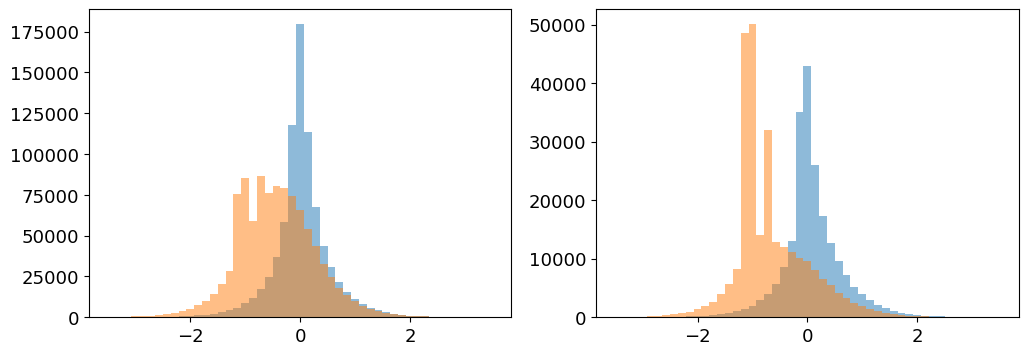

In [267]:
#f, axss = plt.subplots(5, 2, figsize=(12, 15))
#for axs, model in zip(axss.T, ['scratch','finetune']):
#    for i, ax in enumerate(axs):
#        ax.hist(np.hstack([v.reshape(-1) for v in ws_best[model][i].values()]), bins=np.linspace(-1,1,50))
        
#f, axs = plt.subplots(1,2,figsize=(12, 4), sharey=True)
#for ax, model in zip(axs, ['scratch','finetune']):
#    w = np.hstack([np.hstack([v.reshape(-1) for v in ws_best[model][i].values()]) for i in range(5)])
#    print(np.var(w))
#    ax.hist(np.log10(np.abs(w)), bins=50)#np.linspace(-0.5,0.5,100))
#    
#f, axs = plt.subplots(1,2,figsize=(12, 4), sharey=True)
#for ax, model in zip(axs, ['scratch','finetune']):
#    e = np.hstack([np.hstack([v.reshape(-1) for k,v in ws_best[model][i].items() if 'embed' in k]) for i in range(5)])
#    ax.hist(np.log10(np.abs(e)), bins=50)#np.linspace(-0.5,0.5,100))
#    print(np.var(e))

f, axs = plt.subplots(1,2,figsize=(12, 4), sharex=True)
for  model in ['scratch','finetune']:
    #w = np.hstack([np.hstack([v.reshape(-1) for v in ws_d[model][i].values()]) for i in range(5)])
    #e = np.hstack([np.hstack([v.reshape(-1) for k,v in ws_d[model][i].items() if 'embed' in k]) for i in range(5)])

    #axs[0].hist(np.log10(np.abs(w)), bins=np.linspace(-8, 0, 50), alpha=0.5)
    #axs[1].hist(np.log10(np.abs(e)), bins=np.linspace(-8, 0, 50), alpha=0.5)
    
    w = np.hstack([np.hstack([v.reshape(-1) for v in ws_r[model][i].values()]) for i in range(5)])
    e = np.hstack([np.hstack([v.reshape(-1) for k,v in ws_r[model][i].items() if 'embed' in k]) for i in range(5)])

    axs[0].hist(np.log10(np.abs(w)), bins=np.linspace(-3.5,3.5,50), alpha=0.5)
    axs[1].hist(np.log10(np.abs(e)), bins=np.linspace(-3.5,3.5,50), alpha=0.5)
    

In [125]:

def print_output(model, idxs):
    global train_r2s, train_maes, valid_r2s, valid_maes, test_r2s, test_maes, tgts_bf, pred_bf
    measure = []
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    for i, j in enumerate(idxs):
        m =[dat[model][i][j] for dat in [train_r2s, train_maes, valid_r2s, valid_maes, test_r2s, test_maes]]
        measure.append(m)
        x1.append(tgts_bf[i]['valid'].reshape(-1))
        x2.append(tgts_bf[i]['test'].reshape(-1))
        y1.append(pred_bf[i]['valid'][model][j].reshape(-1))
        y2.append(pred_bf[i]['test'][model][j].reshape(-1))
        print(' {:7.3f} {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*m))
    x1 = np.hstack(x1)
    y1 = np.hstack(y1)
    x2 = np.mean(x2, 0)
    y2 = np.mean(y2, 0)
    print('-'*50)
    print(' {:7.3f} {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.mean(measure, 0)))
    print(' {:7.3f} {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.std(measure, 0)))
    print('-'*50)
    print(' {:>7s} {:>7s} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format('-','-',r2_score(x1, y1), mean_absolute_error(x1, y1), r2_score(x2, y2), mean_absolute_error(x2,y2)))
    print()
    return np.array(measure).T

In [165]:
measures = {}
for tune in ['scratch', 'finetune']:
#    i1 = [np.mean(valid_r2s[tune], 0).argmax()] * 5
#    print(tune+'_R2', i1[0], tags[i1[0]])
#    measures[tune+'R2'] = print_output(tune, i1)
#    i2 = [np.mean(valid_maes[tune], 0).argmin()] * 5
#    print(tune+'_MAE', i2[0], tags[i2[0]])
#    measures[tune+'MAE'] = print_output(tune, i2)
    i3 = valid_r2s[tune].argmax(1)
    print(tune+'_ensemble', i3)
    print_output(tune, i3)
    
#    i2 = np.argmax(valid_r2s[k], axis=1)
#    print_output(model, i2)

scratch_ensemble [122  69   7  40  68]
   0.860   5.940 /   0.799  10.271 /   0.225  11.198
   0.915   4.614 /   0.778   8.880 /   0.229  11.592
   0.963   2.227 /   0.809   9.833 /   0.456  10.074
   0.923   3.421 /   0.765  10.308 /   0.171  11.597
   0.938   3.736 /   0.696  11.929 /   0.379  10.766
--------------------------------------------------
   0.920   3.988 /   0.770  10.244 /   0.292  11.046
   0.034   1.240 /   0.040   0.987 /   0.107   0.574
--------------------------------------------------
       -       - /   0.777  10.244 /   0.544   9.487

finetune_ensemble [143  22  25  94  89]
   0.923   4.251 /   0.817  10.095 /   0.576   8.807
   0.966   3.287 /   0.794   8.789 /   0.421  10.118
   0.951   3.609 /   0.821   9.289 /   0.648   8.092
   0.964   2.871 /   0.797   9.726 /   0.571   8.761
   0.942   4.228 /   0.720  10.916 /   0.517   9.894
--------------------------------------------------
   0.949   3.649 /   0.790   9.763 /   0.547   9.134
   0.016   0.536 /   0.03

In [152]:
measures

{'scratchR2': array([[ 0.9421374 ,  0.92205842,  0.92467638,  0.91942593,  0.93935763],
        [ 3.45793104,  4.09457254,  3.44201469,  3.73447013,  2.84613752],
        [ 0.799235  ,  0.75482904,  0.79157877,  0.75919574,  0.65404801],
        [10.62668896,  8.99847507, 11.32993126,  9.49097443, 12.6486702 ],
        [ 0.37474543, -0.29440035, -1.17521379,  0.32857211,  0.40470303],
        [10.04510975, 13.13132381, 15.72965145, 10.44716072, 10.22307873]]),
 'scratchMAE': array([[ 0.92934611,  0.90989555,  0.90299989,  0.91524944,  0.93758019],
        [ 3.85956216,  4.76339626,  4.49269104,  4.54033756,  3.89259076],
        [ 0.78712398,  0.76191057,  0.78430594,  0.72478647,  0.68034752],
        [10.05047321,  8.24884892, 10.03579044, 10.33822727, 12.16225719],
        [ 0.29068337,  0.33624013,  0.23396759,  0.42827566,  0.37656375],
        [10.80103779, 10.53642082, 11.03892326, 10.43285847, 10.76224995]]),
 'finetuneR2': array([[ 0.97421548,  0.94537383,  0.96948215,  0.9447

In [153]:
with open('xgb.output.231016.pkl','rb') as f:
    out_xgb_ = pickle.load(f)
out_xgb = []
for k,v in out_xgb_.items():
    ref = [0,0,0,0,0,0,0]
    for graph, data in v.items():
        if data[1][3] > ref[3]:
            ref = data[1].copy()
    out_xgb.append(ref)
measures['xgb'] = np.array(out_xgb).T[[0,2,3,5,]]

with open('svr.output.231103.pkl','rb') as f:
    out_svr = pickle.load(f)
measures['svr'] = np.array([v['measure'] for v in out_svr.values()]).T[[0,2,3,5,]]


In [154]:
measures.keys()

dict_keys(['scratchR2', 'scratchMAE', 'finetuneR2', 'finetuneMAE', 'xgb', 'svr'])

- p-value

In [155]:
from scipy import stats

for a in ['xgb', 'svr','scratchR2', 'scratchMAE', 'finetuneR2', 'finetuneMAE']:
    s = ''
    for b in ['xgb', 'svr','scratchR2', 'scratchMAE', 'finetuneR2', 'finetuneMAE']:
        v = stats.ttest_ind(measures[a][2], measures[b][2])
        s += f'{v.pvalue:10.5f}'
    print(s)

print()
for a in ['xgb', 'svr','scratchR2', 'scratchMAE', 'finetuneR2', 'finetuneMAE']:
    s = ''
    for b in ['xgb', 'svr','scratchR2', 'scratchMAE', 'finetuneR2', 'finetuneMAE']:
        v = stats.ttest_ind(measures[a][3], measures[b][3])
        s += f'{v.pvalue:10.5f}'
    print(s)



   1.00000   0.55066   0.09657   0.09088   0.02545   0.02985
   0.55066   1.00000   0.00935   0.00537   0.00079   0.00114
   0.09657   0.00935   1.00000   0.90422   0.41610   0.46840
   0.09088   0.00537   0.90422   1.00000   0.28068   0.33357
   0.02545   0.00079   0.41610   0.28068   1.00000   0.93095
   0.02985   0.00114   0.46840   0.33357   0.93095   1.00000

   1.00000   0.66229   0.07845   0.03763   0.02646   0.01771
   0.66229   1.00000   0.02711   0.01206   0.00792   0.00514
   0.07845   0.02711   1.00000   0.62963   0.50642   0.35660
   0.03763   0.01206   0.62963   1.00000   0.86352   0.65717
   0.02646   0.00792   0.50642   0.86352   1.00000   0.77545
   0.01771   0.00514   0.35660   0.65717   0.77545   1.00000


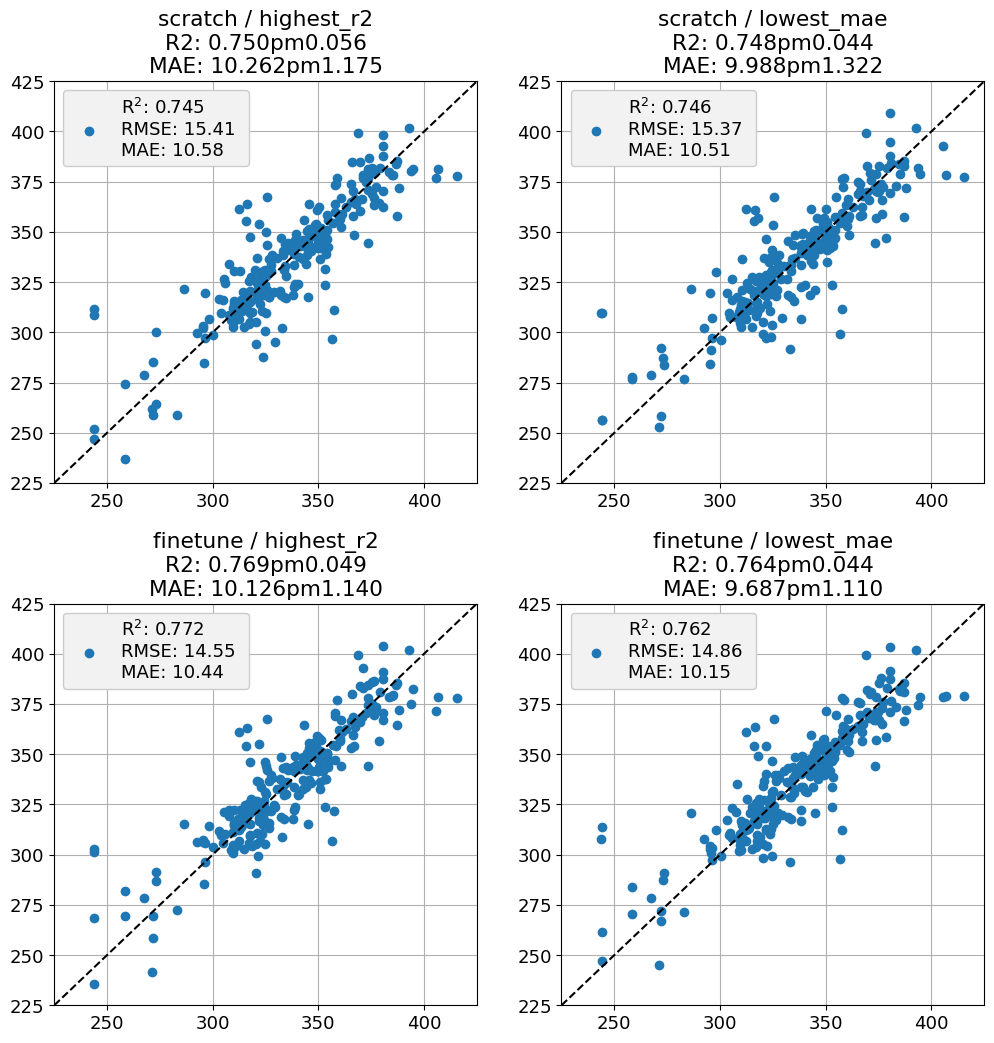

In [88]:
f, axss = plt.subplots(2,2,figsize=(12, 12))
for axs, model in zip(axss, ['scratch','finetune']):
    i_r2 = np.mean(valid_r2s[model], 0).argmax()
    i_mae = np.mean(valid_maes[model], 0).argmin()
    y1 = np.hstack([pred_bf[j]['valid'][model][i_r2].reshape(-1) for j in range(5)]) + 273.15
    y2 = np.hstack([pred_bf[j]['valid'][model][i_mae].reshape(-1) for j in range(5)]) + 273.15
    x = np.hstack([tgts_bf[j]['valid'].reshape(-1) for j in range(5)]) + 273.15
    plot_scatter(axs[0], x, y1, xrange=[225, 425])
    plot_scatter(axs[1], x, y2, xrange=[225, 425])
    axs[0].set_title('{} / highest_r2\nR2: {:.3f}pm{:.3f}\nMAE: {:.3f}pm{:.3f}'.format(model, np.mean(valid_r2s[model], 0)[i_r2], np.std(valid_r2s[model], 0)[i_r2], np.mean(valid_maes[model], 0)[i_r2], np.std(valid_maes[model], 0)[i_r2]))
    axs[1].set_title('{} / lowest_mae\nR2: {:.3f}pm{:.3f}\nMAE: {:.3f}pm{:.3f}'.format(model, np.mean(valid_r2s[model], 0)[i_mae], np.std(valid_r2s[model], 0)[i_mae], np.mean(valid_maes[model], 0)[i_mae], np.std(valid_maes[model], 0)[i_mae]))
f.subplots_adjust(hspace=0.3)
f.savefig('./figs/output.valid.cv.pdf')

In [128]:
model, j = 'finetune', 0
#for i in np.argsort(valid_r2s[model][j] + test_r2s[model][j])[-20:]:
for i in np.argsort(valid_r2s[model][j])[-30:]:
    print('{:5d} {:7.2f} {:9.5f} {:8.4f} {:8.4f} {:8.4f}'.format(i, i/6, valid_r2s[model][j,i], valid_maes[model][j,i], test_r2s[model][j,i], test_maes[model][j,i]))

  121   20.17   0.81083   9.9723   0.4533   9.9580
  140   23.33   0.81139   9.8067   0.3608   9.8631
   73   12.17   0.81160   9.4512   0.6058   8.6915
   16    2.67   0.81198   9.6403   0.3994  10.2344
   63   10.50   0.81249   9.9745   0.3279  10.4110
  110   18.33   0.81317   9.6110   0.2036  11.0857
  142   23.67   0.81322   9.4484   0.3523   9.5959
    3    0.50   0.81363   9.7639   0.4660   9.4930
   81   13.50   0.81449   9.5035   0.4439   9.4840
   51    8.50   0.81485   9.3607   0.4439   9.6385
   99   16.50   0.81519   9.5269   0.2876   9.9980
  122   20.33   0.81543   9.7139   0.4509   9.9031
  128   21.33   0.81574   9.2059   0.2058  10.7515
  126   21.00   0.81587   9.4707   0.3599   9.9632
   79   13.17   0.81736   9.6786   0.2977  10.4592
  141   23.50   0.81763   9.5093   0.4228  10.3069
   75   12.50   0.81819   8.8998   0.3194  10.4742
   58    9.67   0.81852   9.4883   0.3970  10.1368
  109   18.17   0.81858   9.3032   0.4402   9.8372
  105   17.50   0.81876   9.281

In [580]:
#np.argsort(test_r2s['finetune'][0])/6
#test_r2s['finetune'][0][np.argsort(test_r2s['finetune'][0])]
' '.join(['{:5.2f}'.format(v) for v in np.where(valid_r2s[model][j] > 0.72798)[0] / 6])

' 8.33 11.17'

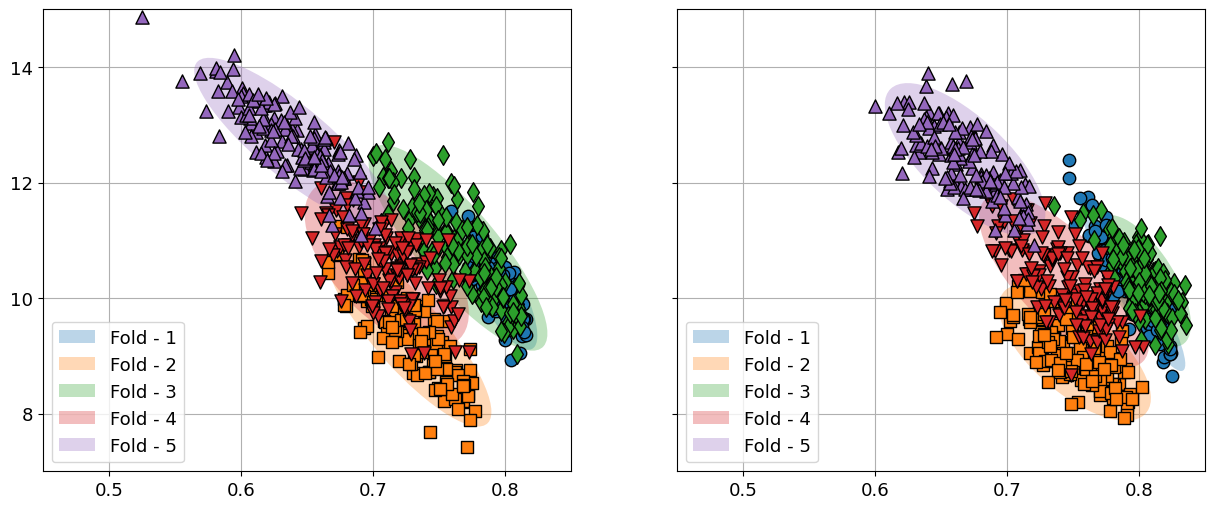

In [177]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def conf_elipse(ax, x, y, std=5, **kwargs):
    cov = np.cov(x, y)
    cor = np.corrcoef(r[i],m[i])[0,1]
    ell_rad_x = np.sqrt(1 + cor)
    ell_rad_y = np.sqrt(1 - cor)
    ell = Ellipse((0,0), width=ell_rad_x*2, height=ell_rad_y*2, **kwargs)
    scale_x = np.sqrt(cov[0,0] * std)
    scale_y = np.sqrt(cov[1,1] * std)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(mean_x, mean_y)
    ell.set_transform(transf + ax.transData)
    ax.add_patch(ell)
    return
    
f, axs = plt.subplots(1,2,figsize=(15,6), sharex=True, sharey=True)
markers = ['o','s','d','v','^']
sizes = [80, 80, 100, 90, 90]
for (model, r), m, ax in zip(valid_r2s.items(), valid_maes.values(), axs):
    for i in range(5):
        ax.scatter(r[i], m[i], marker=markers[i], s=sizes[i], edgecolors=[0,0,0], zorder=99)
        conf_elipse(ax, r[i], m[i], facecolor=mpl.cm.tab10(i), alpha=0.3, zorder=80, label=f'Fold - {i+1}')
    ax.set_xlim([0.45, 0.85])
    ax.set_ylim([7, 15])
    ax.set_yticks([8, 10, 12, 14])
    ax.set_xticks([0.5 ,0.6, 0.7, 0.8])
    ax.grid('on')
    ax.legend(loc='lower left')
f.savefig('./output.cv_performance.pdf')
#    plt.plot(np.linspace(0.5, 1, 20), np.linspace(1, 0.5, 20) - 0.25)


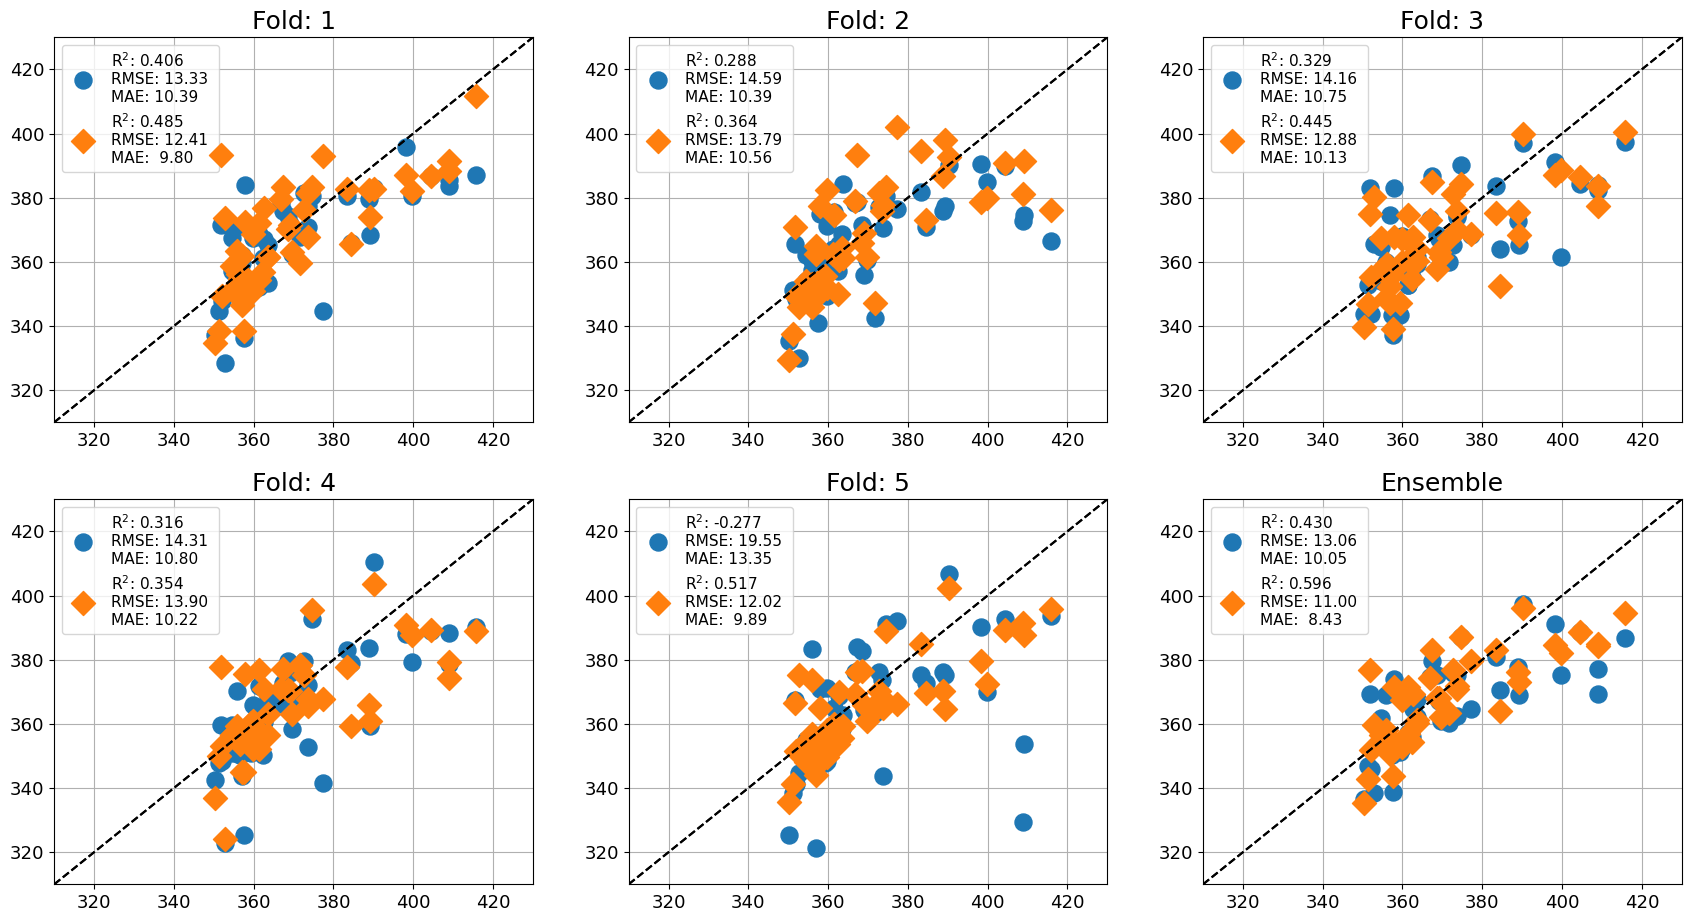

In [179]:
f, axs = plt.subplots(2,3,figsize=(21, 11))
for i, ax in enumerate(axs.reshape(-1)):
    x2 = tgts_bf[0]['test']
    for model in ['scratch','finetune']:
        if i != 5:
            ax.set_title(f'Fold: {i+1}', fontsize=18)
            y = pred_best[model]['test'][i]
        else:
            ax.set_title('Ensemble', fontsize=18)
            y = np.mean(pred_best[model]['test'], axis=0)
        plot_scatter(ax, x2+273.15, y+273.15, xrange=[310, 430], s=150, marker='o' if model == 'scratch' else 'D')
        ax.grid('on')
        ax.legend(loc='upper left', fontsize=11)
f.savefig('./figs/output.cv.test.pdf')

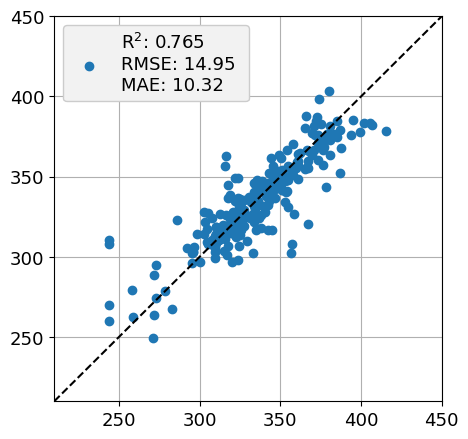

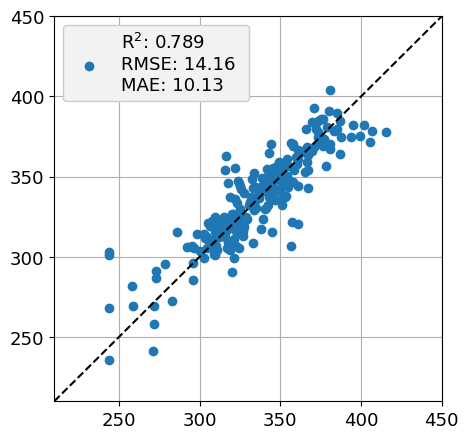

In [25]:
for model in ['scratch','finetune']:
    f, ax = plt.subplots(1,1,figsize=(5,5))
    j = np.argmax(valid_r2s[model].mean(0))
    x1 = np.hstack([tgts_bf[i]['valid'] for i in range(5)])
    y = np.hstack([pred_bf[i]['valid'][model][j].astype(float) for i in range(5)])
    plot_scatter(ax, x1+273.15, y + 273.15, xrange=[210, 450])
    x = np.linspace(0,500,100)
    #ax.plot(x, x+std)
    #ax.plot(x, x-std)
#    if model == 'scratch':
#        f.savefig('./output.sc.test.pdf')
#    else:
#        f.savefig('./output.ft.test.pdf')

- fingerprint 간 거리 활용
- 데이터의 공통첨을 찾기. 
- 각 fold별로 잘 맞추고 못 맞추는 것들이 구분이 되도록.
- 모노머별로? 특정 모노머의 포함 여부를 체크?

In [31]:
from src.model.base import GraphNet
from src.utils.data import CrossValidation
from src.utils.dataset import BaseDataset, basic_collate_fn
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs import TanimotoSimilarity, DiceSimilarity

df1 = pd.read_csv('./data/fpolymers_230823.tg.train.csv')
df2 = pd.read_csv('./data/fpolymers_230823.tg.test.csv')

col_s = [f'SMILES_{x}' for x in 'ABCDE']
col_w = [f'FR_{x}' for x in 'ABCDE']

ss1 = df1[col_s].values.reshape(-1)
ws1 = df1[col_w].fillna(0).values.reshape(-1)
ss1[ws1 == 0] = ''
ss1 = ss1.reshape(-1,5)
ws1 = ws1.reshape(-1,5)
ws1 /= ws1.sum(1).reshape(-1,1)

ss2 = df2[col_s].values.reshape(-1)
ws2 = df2[col_w].fillna(0).values.reshape(-1)
ss2[ws2 == 0] = ''
ss2 = ss2.reshape(-1,5)
ws2 = ws2.reshape(-1,5)
ws2 /= ws2.sum(1).reshape(-1,1)

ss = np.vstack([ss1, ss2])
ws = np.vstack([ws1, ws2])
uss = [s for s in np.sort(np.unique(ss.reshape(-1))) if s != '']
usfs = [s for s in uss if 'F' in s]
uscs = [s for s in uss if 'F' not in s] 

mapper = {'':''}
mapper.update({s:f'f{i:02d}' for i,s in enumerate(usfs)})
mapper.update({s:f'c{i:02d}' for i,s in enumerate(uscs)})
_mapper = {v:k for k,v in mapper.items()}

qs1 = np.array([' '.join([mapper[s] for s in _ss if s != '']) for _ss in ss1])
qw3s1 = np.array([' '.join([f'{mapper[s]} {w:.3f}' for s, w in zip(_ss, _ws) if s != '']) for _ss, _ws in zip(ss1, ws1)])
qw2s1 = np.array([' '.join([f'{mapper[s]} {w:.2f}' for s, w in zip(_ss, _ws) if s != '']) for _ss, _ws in zip(ss1, ws1)])

qs2 = np.array([' '.join([mapper[s] for s in _ss if s != '']) for _ss in ss2])
qw3s2 = np.array([' '.join([f'{mapper[s]} {w:.3f}' for s, w in zip(_ss, _ws) if s != '']) for _ss, _ws in zip(ss2, ws2)])
qw2s2 = np.array([' '.join([f'{mapper[s]} {w:.2f}' for s, w in zip(_ss, _ws) if s != '']) for _ss, _ws in zip(ss2, ws2)])

In [37]:
cv = CrossValidation(5, n_data=df1.shape[0], seed=100, return_index=True)
def get_count_from_fold(s):
    global ss1, ss2, cv, tgts_bf, best_preds
    _smask = (ss1 == s).sum(1).astype(bool)
    trs = []
    for i in range(5):
        trs.append(_smask[cv[i][0]].sum())
    test = (ss2 == s).sum()
    if test == 0 or test > 9:
        return
    if np.sum(_smask) != 0: return
    print('SMILES: ',s)
    print(' '.join([f'{c:7d}' for c in trs]), f'      / {np.sum(_smask):5d}  {test:5d} / ')
    for i in np.where((ss2 == s).sum(1))[0]:
        t = tgts_bf[0]['test'][i]
        print(f'No.{i:3d} / {t:7.2f}')
        q1, q2, q3 = qs2[i], qw2s2[i], qw3s2[i]
        for model in ['scratch','finetune']:
            val = [pred_best[model]['test'][j][i].astype(float) for j in range(5)]
            val.append(np.mean(val))
            print(' '.join(['{:7.2f}'.format(v) for v in val]))
    print()
    
for s in usfs:
    get_count_from_fold(s)

for s in uscs:
    get_count_from_fold(s)


SMILES:  CC(=C)C(=O)OC1CC2CCC1(C)C2(C)C
      0       0       0       0       0       /     0      4 / 
No.  4 /  135.80
 110.50   78.61  109.18  105.56   56.25   92.02
 118.36   99.81  110.40  101.15  118.30  109.61
No.  5 /  135.84
 112.30   87.47  110.91  115.18   80.47  101.27
 115.17  102.41  104.28  106.18  114.43  108.49
No.  6 /  110.26
 107.44   98.91  110.50  109.85  102.09  105.76
 109.48  103.42  102.14  104.62  111.60  106.25
No. 29 /  131.29
 113.52  118.71  111.12  115.93  119.47  115.75
 113.75  115.34  113.21  116.17  116.22  114.94

SMILES:  CC1(C)[C@H]2CC[C@]1(C)C(C2)OC(=O)C=C
      0       0       0       0       0       /     0      1 / 
No. 33 /   93.70
 105.27   99.21  100.35   92.90  103.09  100.16
 106.32   95.98   99.90   97.75   96.09   99.21



In [36]:
cv = CrossValidation(5, n_data=df1.shape[0], seed=100, return_index=True)
for i, (s_, t) in enumerate(zip(ss2, tgts_bf[0]['test'])):
#    if i not in [5, 30, 34]: continue
    print(f'No.{i:3d} /','/'.join([f'    F_{j} ' for j in range(5)]),f'/ {t:6.2f}')
    for j, s in enumerate(s_):
        if s == '':
            print(f'Mon.{j}  /','/'.join(['    --- ']*5))
        else:
            print(f'Mon.{j}  /','/'.join([f'    {(ss1[cv[k][0]] == s).sum():3d} ' for k in range(5)]))
    for mdn, model in zip(['SC','FT'],['scratch','finetune']):
        p_ = [pred_best[model]['test'][j][i] for j in range(5)]
        p_.extend([np.mean(p_), np.mean(p_) - t])
        print(f'  {mdn}   /','/'.join([f' {p:6.2f} ' for p in p_]))
    print()

No.  0 /     F_0 /    F_1 /    F_2 /    F_3 /    F_4  /  89.28
Mon.0  /       4 /      6 /      5 /      4 /      5 
Mon.1  /      88 /     89 /     85 /     88 /     94 
Mon.2  /     128 /    127 /    131 /    129 /    129 
Mon.3  /      98 /    100 /     93 /     95 /     94 
Mon.4  /     156 /    155 /    157 /    157 /    155 
  SC   /   88.00 /  84.21 /  82.14 /  77.03 /  83.08 /  82.89 /  -6.39 
  FT   /   83.78 /  77.74 /  81.41 /  83.44 /  80.48 /  81.37 /  -7.91 

No.  1 /     F_0 /    F_1 /    F_2 /    F_3 /    F_4  /  82.92
Mon.0  /      43 /     40 /     40 /     38 /     39 
Mon.1  /      88 /     89 /     85 /     88 /     94 
Mon.2  /     128 /    127 /    131 /    129 /    129 
Mon.3  /      98 /    100 /     93 /     95 /     94 
Mon.4  /     156 /    155 /    157 /    157 /    155 
  SC   /   87.53 /  85.71 /  81.83 /  77.33 /  82.53 /  82.99 /   0.07 
  FT   /   82.99 /  80.45 /  86.07 /  83.06 /  83.81 /  83.28 /   0.36 

No.  2 /     F_0 /    F_1 /    F_2 /    F_3 

In [172]:
from rdkit import Chem
from rdkit.Chem import Draw

smiles = ['C=C(C(=O)O)C(F)(F)F', 'CC1(C)[C@H]2CC[C@]1(C)C(C2)OC(=O)C=C', 'CC1C2CC(C1(C)C)CC2C3CCCC(C3)OC(=O)C=C', 'CCCOC(=O)C(C)=C', ]
fig = Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in smiles], molsPerRow=1, subImgSize=(500,500), useSVG=True)

with open('extra_mol.svg','w') as f:
    f.write(fig.data)

- 처음보는 monomer가 포함된 데이터에 대한 예측 성능

['-23.54', '-48.37', '-24.93', '-20.66', '-55.37', '-34.57']
['-20.67', '-33.43', '-31.56', '-29.66', '-21.41', '-27.35']
['-32.55', '  5.53', ' -9.01', '-35.67', ' 14.88', '-11.37']
[' 15.63', '  1.67', ' -8.56', ' -9.65', '-11.04', ' -2.39']
[' 11.57', '  5.51', '  6.65', ' -0.80', '  9.39', '  6.46']
[' 12.62', '  2.28', '  6.20', '  4.05', '  2.39', '  5.51']


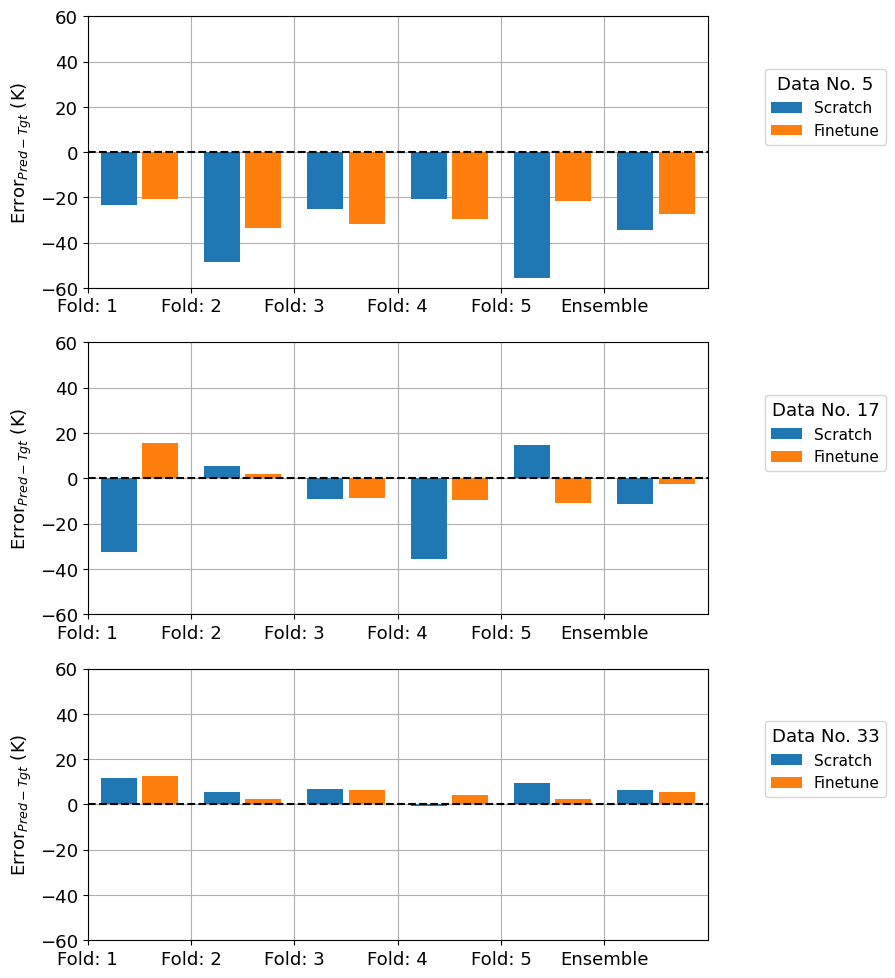

In [40]:
f, axs = plt.subplots(3,1,figsize=(8, 12))
for i, ax in zip([5,17,33], axs):
    t = tgts_bf[0]['test'][i]
    p1 = np.array(pred_best['scratch']['test'])[:, i]
    p2 = np.array(pred_best['finetune']['test'])[:, i]
    p1 = np.hstack([p1, p1.mean()])
    p2 = np.hstack([p2, p2.mean()])
    ax.bar(np.linspace(1,11,6)-0.4, p1 - t, width=0.7, zorder=10, label='Scratch')
    ax.bar(np.linspace(1,11,6)+0.4, p2 - t, width=0.7, zorder=10, label='Finetune')
    print([f'{v:6.2f}' for v in p1 - t])
    print([f'{v:6.2f}' for v in p2 - t])
    ax.axhline(0, ls='--', color=[0,0,0], zorder=99)
    ax.grid('on')
    ax.set_xticks([0,2,4,6,8,10],labels=[f'Fold: {i}' for i in range(1,6)] + ['Ensemble'])
    ax.set_ylim([-60,60])
    ax.set_xlim([0,12])
    if i != 36:
        ax.legend(loc='lower right', title=f'Data No. {i}', fontsize=11, bbox_to_anchor=(1.3,0.5))
    else:
        ax.legend(loc='upper right', title=f'Data No. {i}', fontsize=11, bbox_to_anchor=(1.3,0.5))
    ax.set_ylabel('Error$_{Pred-Tgt}$ (K)')
f.savefig('./figs/output.ext.test.pdf')

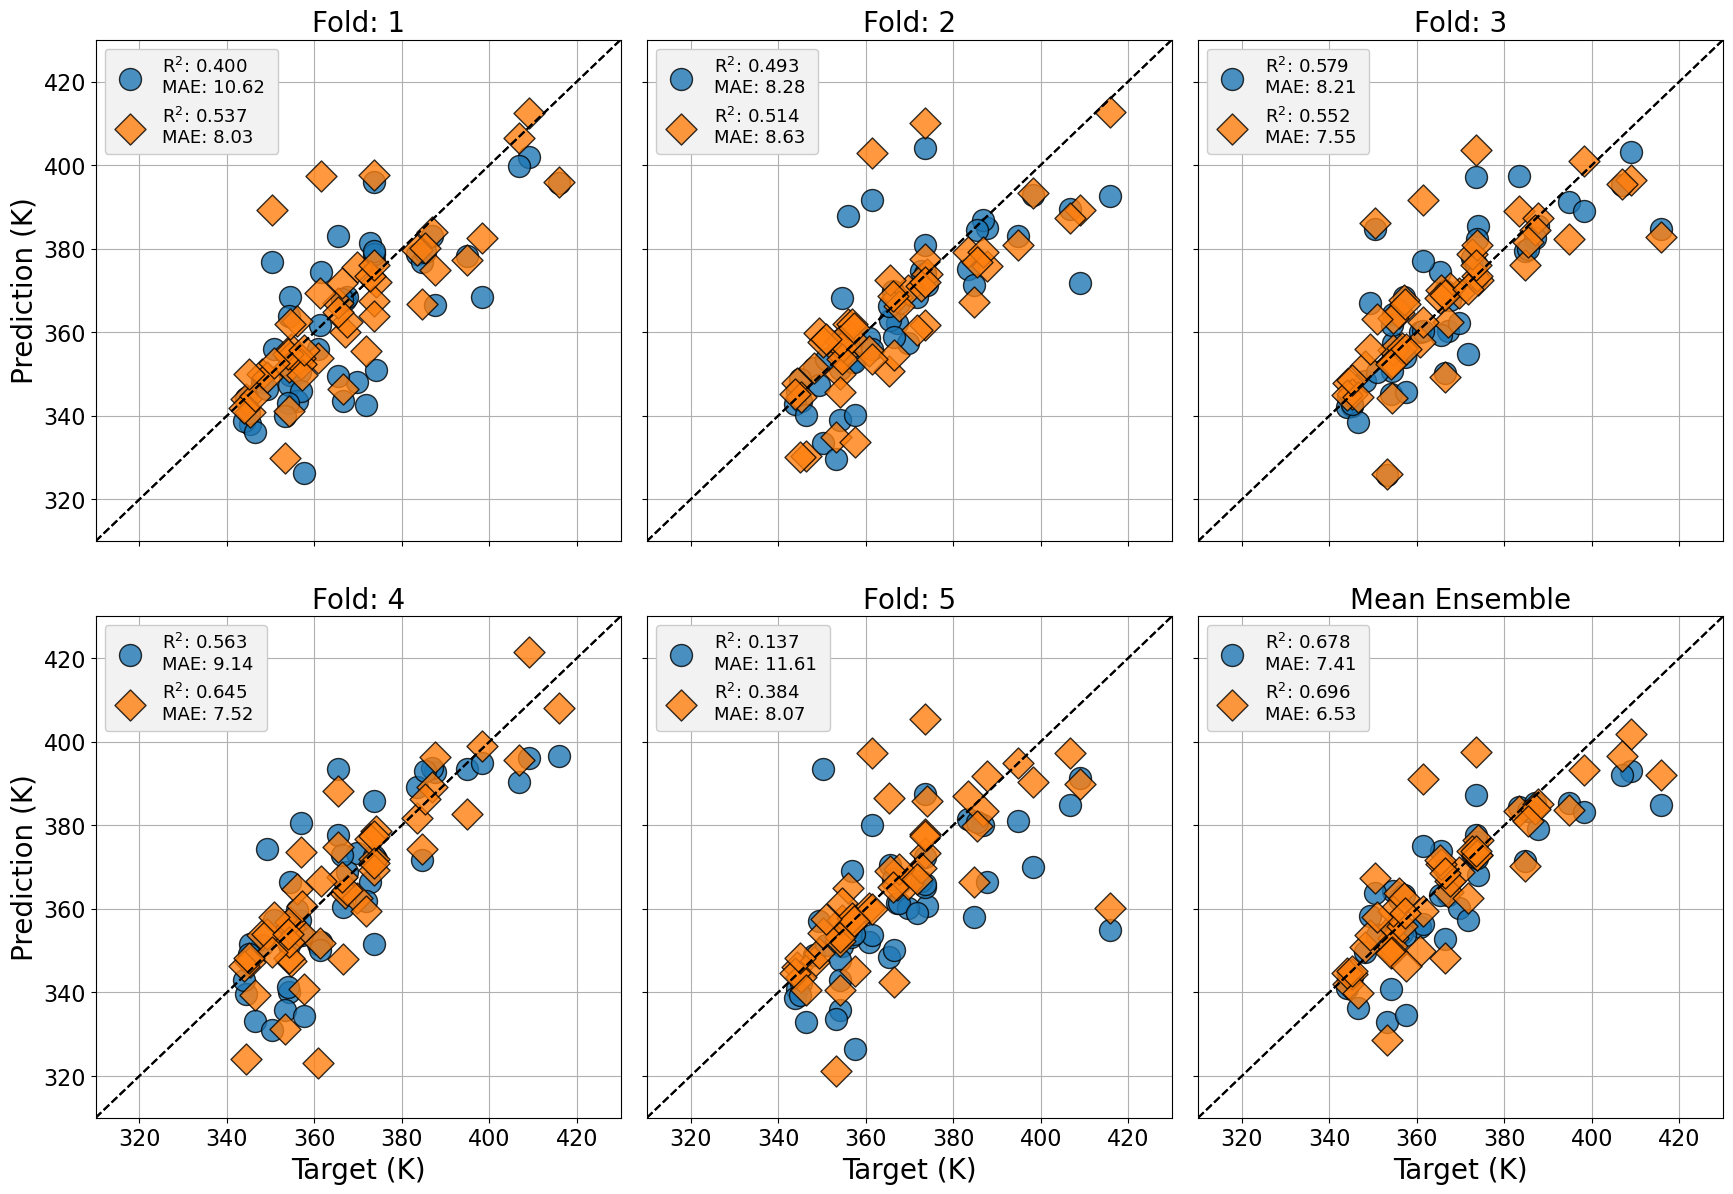

In [200]:
f, axs = plt.subplots(2,3,figsize=(21,14), sharex=True, sharey=True)
x = tgts_bf[0]['test'] + 273.15
axs = axs.reshape(-1)
for i in range(2):
    for j, ax in enumerate(axs[:5]):
        plot_scatter(ax, x, best_preds[j,i,1]+273.15, metrics=['R2','MAE'], fmts=['{:.3f}','{:.2f}'], xrange=[310, 430], s=250, marker='o' if i == 0 else 'D', alpha=0.8, edgecolor=[0,0,0])
        ax.set_title(f'Fold: {j+1}', fontsize=20)
    axs[-1].set_title('Mean Ensemble', fontsize=20)
    p = best_preds[:, i, 1]
    plot_scatter(axs[-1], x, best_preds[:, i, 1].mean(0)+273.15, metrics=['R2','MAE'], fmts=['{:.3f}','{:.2f}'], xrange=[310, 430], s=250, marker='o' if i == 0 else 'D', alpha=0.8, edgecolor=[0,0,0])
axs[0].set_ylabel('Prediction (K)', fontsize=20)
axs[3].set_ylabel('Prediction (K)', fontsize=20)
for ax in axs[3:]:
    ax.set_xlabel('Target (K)', fontsize=20)
for ax in axs:
#    ax.legend(loc='lower center', fontsize=11, ncol=2, title='Scratch               Finetune', bbox_to_anchor=[0.5,-0.25])
    ax.grid()
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
f.subplots_adjust(wspace=0.05, hspace=0.15)
f.savefig('output.cv.test.pdf')

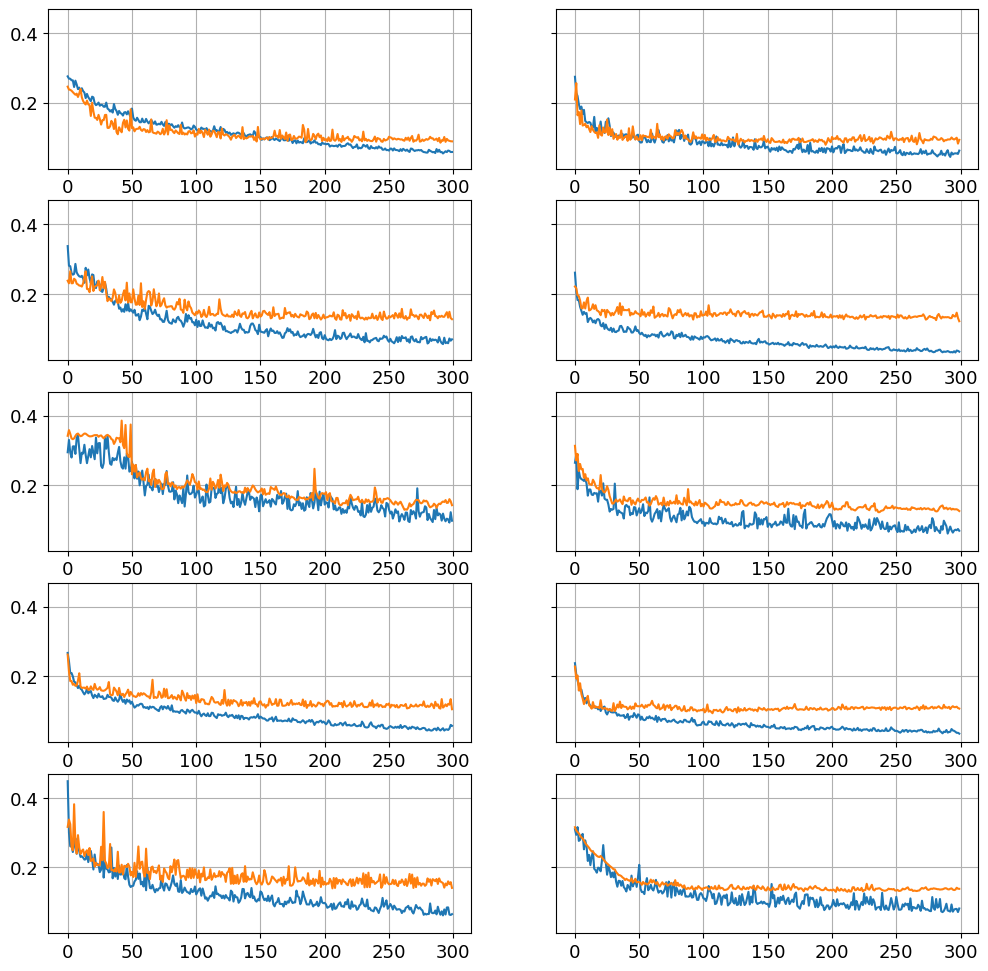

In [327]:
final_models = {
    'scratch':[
        ['b08_g90_s25', 'graph', 'sing_cg_64_6'],
        ['b32_g90_s50', 'graph', 'sing_cg_64_6'],
        ['b64_g90_s25', 'graph', 'sing_cg_64_4'],
        ['b08_g90_s50', 'mol', 'sing_dnn_128_2'],
        ['b32_g90_s25', 'concat', 'sing_cg_64.128_6.2']],
    'finetune':[
        ['b32_g90_s50', 'graph', 'sing_cg_64_4'],
        ['b08_g90_s25', 'concat', 'sing_cg_64.128_6.2'],
        ['b64_g90_s50', 'graph', 'sing_cg_64_4'],
        ['b16_g90_s50', 'graph', 'sing_cg_64_6'],
        ['b64_g90_s25', 'graph', 'sing_cg_64_6']]
}

f, axs = plt.subplots(5,2,figsize=(12,12), sharey=True)
for model, final_tags in final_models.items():
    for i, (a, b, c) in enumerate(final_tags):
        path = os.path.join('/home/jhyang/WORKSPACES/MODELS/fpoly/r100',
                            f'{model}_gs', a, b, c, f'n_{i:03d}', 'best.loss.txt')
        t, v = np.loadtxt(path)
        axs[i,int(model == 'finetune')].plot(t)
        axs[i,int(model == 'finetune')].plot(v)
for ax in axs.reshape(-1): ax.grid('on')

# Data inspect

In [1066]:
import pandas as pd
import numpy as np
from src.utils.data import CrossValidation
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Ellipse

import pickle
from rdkit import Chem
from rdkit.Chem import Draw
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

- load data

In [757]:
def parse_df(df):
    for x in 'ABCDE':
        m = df[f'FR_{x}'].isna() | (df[f'FR_{x}'] == 0)
        df.loc[m, f'FR_{x}'] = 0
        df.loc[m, f'SMILES_{x}'] = ''
        m = df[f'SMILES_{x}'].isna()
        df.loc[m, f'FR_{x}'] = 0
        df.loc[m, f'SMILES_{x}'] = ''
    return df
    
train_df = parse_df(pd.read_csv('./data/fpolymers_221123.train.csv'))
test_df = parse_df(pd.read_csv('./data/fpolymers_221123.test.csv'))
n1, n2 = train_df.shape[0], test_df.shape[0]
CV = CrossValidation(n_fold=5, n_data=train_df.shape[0], seed=100, return_index=True)

col_smiles = [f'SMILES_{x}' for x in 'ABCDE']
col_frs = [f'FR_{x}' for x in 'ABCDE']
col_tgs = ['TG']
smiles = np.sort(np.unique(np.vstack([train_df[col_smiles].values, test_df[col_smiles].values])))

mapper = {s:f'f{i:02d}' for i, s in enumerate([_s for _s in smiles if 'F' in _s])}
mapper.update({s:f'c{i:02d}' for i, s in enumerate([_s for _s in smiles if 'F' not in _s])})
mapper.update({v:k for k,v in mapper.items()})
mapper.update({'':''})
dfs = {}
for i in range(5):
    d = pickle.load(open(f'/home/jhyang/WORKSPACES/MODELS/fpoly/r100/scratch_gs/b08_g90_s25/concat/sing_cg_64.128_6.2/n_00{i}/best.valid.pkl','rb'))
    tidx, vidx = CV[i]
    v = np.sum(train_df.iloc[vidx].sort_values('ID').ID.values != np.sort(d[0]))
    if v != 0: print(f'Inconsistent data in Fold {i}: ', v)

    _part = train_df.loc[tidx, ['ID'] + col_smiles + col_frs + col_tgs].sort_values('ID').copy()
    _test = test_df[['ID'] + col_smiles + col_frs + col_tgs].sort_values('ID').copy()
    _smiles = np.unique(_part[col_smiles].values.reshape(-1))
    for col in col_smiles:
        _part[col] = _part[col].map(lambda x: mapper[x])
        _test[col] = _test[col].map(lambda x: mapper[x] if x in _smiles else f'N{mapper[x]}')
    dfs[i] = _part, _test

- load embeddings

In [966]:
for k, v in embeddings.items():
    print(k, v.shape)

mol_sing (294, 64)
graph_sing (294, 64)
concat_sing (294, 128)


In [ ]:
def balancing(embedding, balance=1.1):
    e = embedding.copy()
    n = int(e.shape[1]/4)
    e[:, :n] = e[:, :n] * balance
    e[:, 3*n:] = e[:, 3*n:] * balance
    return e

embeddings = {k:np.vstack([_v for _v in v.values()][:2]) for k,v in pickle.load(open('/home/jhyang/WORKSPACES/scaled_embeddings_v2.pkl','rb')).items()}

tsne = TSNE(perplexity=60, random_state=100)
#gm   = BayesianGaussianMixture(n_components=5, random_state=1, covariance_type='diag')
gm   = GaussianMixture(n_components=5, random_state=1, covariance_type='diag')
#bvec = balancing(np.vstack(embeddings), balance=1.5)
bvecs = [embeddings['mol_sing'], embeddings['graph_sing'], 
         balancing(embeddings['concat_sing'], 1.1)]
tvecs = [tsne.fit_transform(bvec) for bvec in bvecs]
lbls  = [gm.fit_predict(v) for v in bvecs]

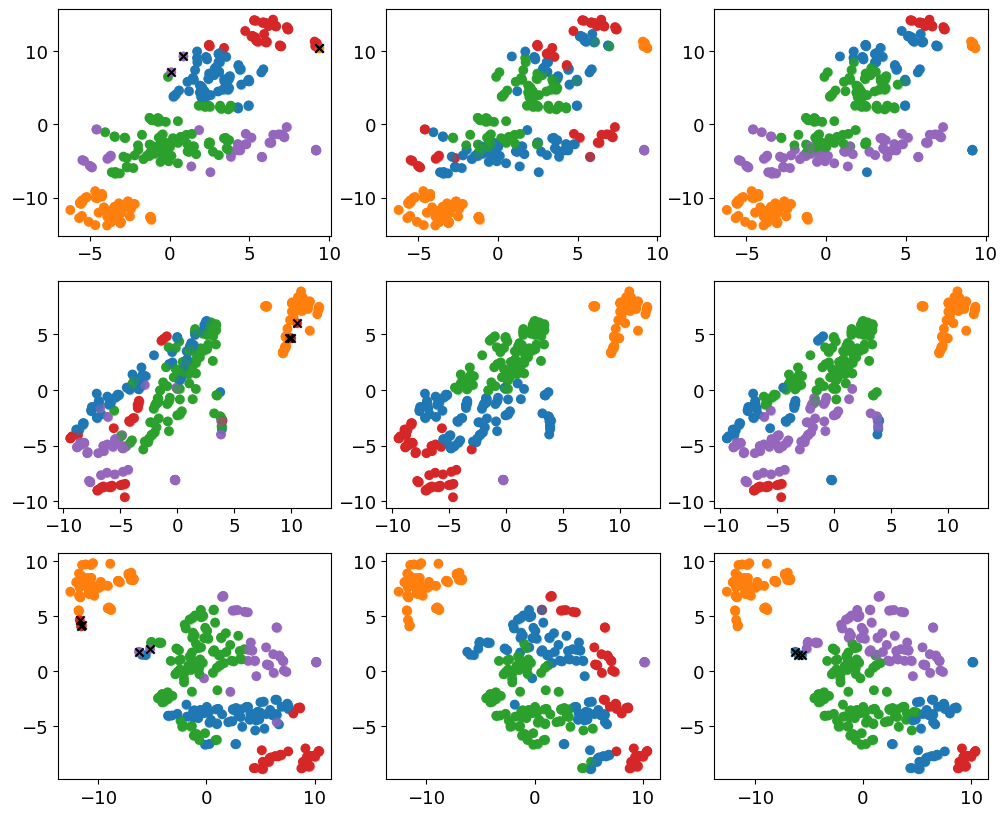

In [1068]:
f, axss = plt.subplots(3,3,figsize=(12,10))
for axs, tvec in zip(axss, tvecs):
    for ax, lbl in zip(axs, lbls):
        ax.scatter(*tvec.T, c=[mpl.cm.tab10(l) for l in lbl])
        for i in np.sort(np.unique(lbl)):
            m = lbl == i
            xy = tvec[m]
    
            d = np.sqrt(np.square(xy[:, np.newaxis, :] - xy).sum(-1))
            dm = np.sum(d < 8, 1) > 3
            x, y = xy[dm].T
    
            cov = np.cov(x, y)
            lamb, v = np.linalg.eig(cov)
            mean_x = np.mean(x)
            mean_y = np.mean(y)
            ellip = Ellipse([mean_x, mean_y], width=lamb[0] * 2, height=lamb[1] * 2, 
                            angle=np.rad2deg(np.arctan2(*v[:,0][::-1])),
                            facecolor=mpl.cm.tab10(i), alpha=0.3)
    
#            ax.add_patch(ellip)
            ax.scatter(*tvec[m].T, color=mpl.cm.tab10(i), alpha=0.3)
            ax.scatter(*xy[~dm].T, marker='x', color=[0,0,0], zorder=19)


#        ax.set_xticks([])
#        ax.set_yticks([])
#f.subplots_adjust(wspace=0.02, hspace=0.02)

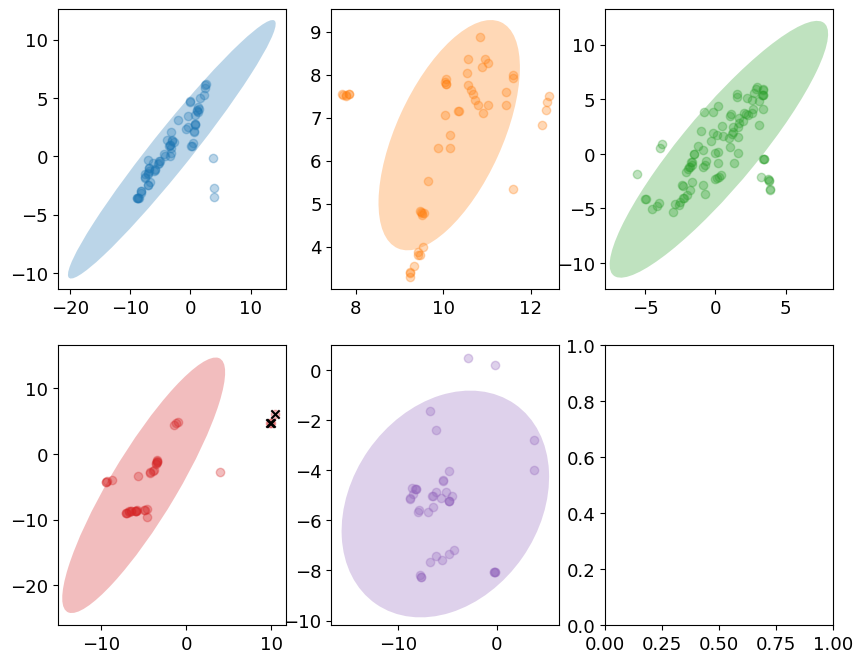

In [1071]:
from matplotlib.patches import Ellipse
from matplotlib import transforms

tvec = tvecs[1]
lbl  = lbls[0]

f, axs = plt.subplots(2,3,figsize=(10,8))
for l, ax in zip(np.sort(np.unique(lbl)), axs.reshape(-1)):
    m = l == lbl
    xy = tvec[m]
    d = np.sqrt(np.square(xy[:, np.newaxis, :] - xy).sum(-1))
    dm = np.sum(d < 8, 1) > 3
    x, y = xy[dm].T
    cov = np.cov(x, y)
    lamb, v = np.linalg.eig(cov)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    ellip = Ellipse([mean_x, mean_y], width=lamb[0] * 2, height=lamb[1] * 2, 
                    angle=np.rad2deg(np.arctan2(*v[:,0][::-1])),
                    facecolor=mpl.cm.tab10(l), alpha=0.3)
    
    ax.add_patch(ellip)
    ax.scatter(*tvec[m].T, color=mpl.cm.tab10(l), alpha=0.3)
    ax.scatter(*xy[~dm].T, marker='x', color=[0,0,0], zorder=19)

In [23]:
from src.utils.features import load_ptable_matrix, RDKitMoleculeDescriptor
rdkmd = RDKitMoleculeDescriptor()
#a, b = load_ptable_matrix()
#a
s = ''
for d in rdkmd.descriptors:
    s += f'{d} / '
    if len(s) > 80:
        print(s)
        s = ''

MaxEStateIndex / MinEStateIndex / MaxAbsEStateIndex / MinAbsEStateIndex / qed / MolWt / 
HeavyAtomMolWt / ExactMolWt / NumValenceElectrons / NumRadicalElectrons / MaxPartialCharge / 
MinPartialCharge / MaxAbsPartialCharge / MinAbsPartialCharge / FpDensityMorgan1 / 
FpDensityMorgan2 / FpDensityMorgan3 / BCUT2D_MWHI / BCUT2D_MWLOW / BCUT2D_CHGHI / 
BCUT2D_CHGLO / BCUT2D_LOGPHI / BCUT2D_LOGPLOW / BCUT2D_MRHI / BCUT2D_MRLOW / BalabanJ / 
BertzCT / Chi0 / Chi0n / Chi0v / Chi1 / Chi1n / Chi1v / Chi2n / Chi2v / Chi3n / Chi3v / 
Chi4n / Chi4v / HallKierAlpha / Ipc / Kappa1 / Kappa2 / LabuteASA / PEOE_VSA1 / PEOE_VSA10 / 
PEOE_VSA11 / PEOE_VSA12 / PEOE_VSA13 / PEOE_VSA14 / PEOE_VSA2 / PEOE_VSA3 / PEOE_VSA4 / 
PEOE_VSA5 / PEOE_VSA6 / PEOE_VSA7 / PEOE_VSA8 / PEOE_VSA9 / SMR_VSA1 / SMR_VSA10 / 
SMR_VSA2 / SMR_VSA3 / SMR_VSA4 / SMR_VSA5 / SMR_VSA6 / SMR_VSA7 / SMR_VSA8 / SMR_VSA9 / 
SlogP_VSA1 / SlogP_VSA10 / SlogP_VSA11 / SlogP_VSA12 / SlogP_VSA2 / SlogP_VSA3 / 
SlogP_VSA4 / SlogP_VSA5 / SlogP_VSA

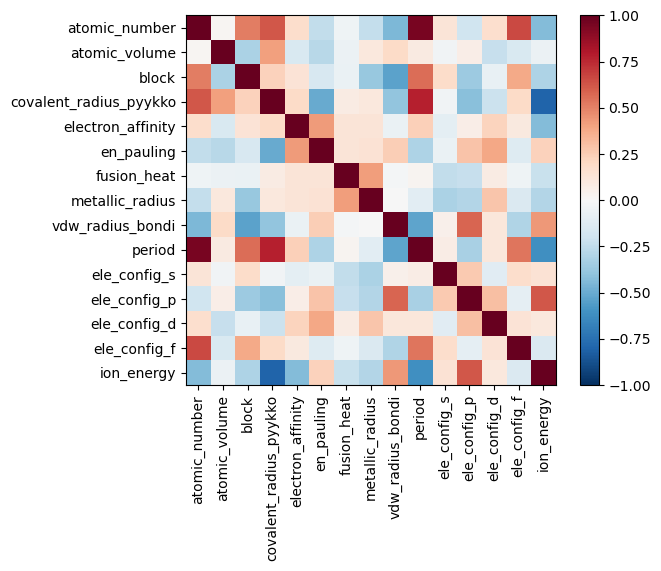

In [19]:
im = plt.imshow(np.corrcoef(a.T), vmin=-1, vmax=1, cmap='RdBu_r')
_ = plt.xticks(range(len(b)), labels=b, rotation=90)
_ = plt.yticks(range(len(b)), labels=b)
plt.colorbar(im)